# 循环神经网络（RNN）作业

指导教师：胡俊峰

负责助教：苏亚鲁，李浩然

注意：仅需要提交.ipynb文件，请**不要**将下发压缩包中的其他文件一并交上。

截止日期：6月4日24点

## 第零部分

### 0.1 可视化工具visdom

visdom是Facebook专为pytorch开发的实时可视化工具包，灵活高效且界面美观。在深度学习领域，模型训练是一个必须的过程，因此可以借助visdom实时监听并可视化一些数据，如损失值loss，正确率acc等。

要使用visdom，需先完成以下步骤：
* 在终端执行python -m visdom.server，开启监听命令；
* 成功开启后，会返回一个网址，在浏览器里输入该网址，进入后即可显示visdom的主界面；

In [181]:
from visdom import Visdom 
import numpy as np
import time
import torch

#### 监听单一数据

In [182]:
# 实例化一个窗口
wind = Visdom()
# 初始化窗口信息
wind.line([0.], # Y的第一个点的坐标
		  [0.], # X的第一个点的坐标
		  win = 'train_loss', # 窗口的名称
		  opts = dict(title = 'train_loss') # 图像的标例
)
# 更新数据
for step in range(10):
	# 随机获取loss,这里只是模拟实现
	loss = np.random.randn() * 0.5 + 2
	wind.line([loss], [step], win = 'train_loss', update = 'append')
	time.sleep(0.5)

Setting up a new session...


#### 监听多条数据

In [183]:
# 实例化窗口
wind = Visdom()
# 初始化窗口参数
wind.line([[0.,0.]],[0.], win = 'train', opts = dict(title = 'loss&acc', legend = ['loss','acc']))
# 更新窗口数据
for step in range(10):
	loss = 0.2 * np.random.randn() + 1
	acc = 0.1 * np.random.randn() + 0.5
	wind.line([[loss, acc]], [step], win = 'train', update = 'append')
	time.sleep(0.5)

Setting up a new session...


#### 可视化数据集

In [184]:
from torchvision import datasets, transforms

# 加载数据集
train_loader = torch.utils.data.DataLoader(datasets.MNIST(
    r'mnist-data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])),batch_size=128,shuffle=True)
sample=next(iter(train_loader)) # 通过迭代器获取样本
viz = Visdom(env='my_visual') # 注意此时创建了新环境，请在界面中选择该环境
# sample[0]为样本数据，sample[1]为类别，nrow=16表示每行显示16张图像
viz.images(sample[0], nrow=16, win='mnist', opts=dict(title='mnist'))

Setting up a new session...


'mnist'

### 0.2 Pytorch中hook的使用

In [185]:
import torch

# x,y 为leaf节点，也就是说，在计算的时候，PyTorch只会保留此节点的梯度值
x = torch.tensor([3.], requires_grad=True)
y = torch.tensor([5.], requires_grad=True)

# a,b均为中间值，在计算梯度时，此部分会被释放掉
a = x + y
b = x * y

c = a * b

# 新建列表，用于存储Hook函数保存的中间梯度值
a_grad = []
def hook_grad(grad):
    a_grad.append(grad)

# register_hook的参数为一个函数
handle = a.register_hook(hook_grad)
c.backward()

# 只有leaf节点才会有梯度值
print('gradient:',x.grad, y.grad, a.grad, b.grad, c.grad)
# Hook函数保留下来的中间节点a的梯度
print('a_grad:', a_grad[0])
# 移除Hook函数
handle.remove()

gradient: tensor([55.]) tensor([39.]) None None None
a_grad: tensor([15.])


/var/folders/yy/dhpnrkdj07j_mvzvjnh9lvdr0000gn/T/ipykernel_98969/3895428097.py:23: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1685344154285/work/build/aten/src/ATen/core/TensorBody.h:492.)
  print('gradient:',x.grad, y.grad, a.grad, b.grad, c.grad)


In [186]:
import torch.nn as nn

# 构建网络，包含一个卷积层和一个池化层
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3)
        self.pool1 = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        return x
# 初始化网络
net = Net()
# detach将张量分离
net.conv1.weight[0].detach().fill_(1)
net.conv1.weight[1].detach().fill_(2)
net.conv1.bias.detach().zero_()

# 构建两个列表用于保存信息
fmap_block = []
input_block = []

def forward_hook(module, data_input, data_output):
    fmap_block.append(data_output)
    input_block.append(data_input)

# 注册Hook
net.conv1.register_forward_hook(forward_hook)

# 输入数据
fake_img = torch.ones((1, 1, 4, 4))
output = net(fake_img)

# 观察结果
# 卷积神经网络输出维度和结果
print("output share:{}\noutput value:{}\n".format(output.size(),output))

# 卷积神经网络Hook函数返回的结果
print("feature map share:{}\noutput value:{}\n".format(fmap_block[0].shape,fmap_block[0]))

# 输入的信息
print("input share:{}\ninput value:{}\n".format(input_block[0][0].size(),input_block[0][0]))

output share:torch.Size([1, 2, 1, 1])
output value:tensor([[[[ 9.]],

         [[18.]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

feature map share:torch.Size([1, 2, 2, 2])
output value:tensor([[[[ 9.,  9.],
          [ 9.,  9.]],

         [[18., 18.],
          [18., 18.]]]], grad_fn=<ConvolutionBackward0>)

input share:torch.Size([1, 1, 4, 4])
input value:tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])



## 第一部分：实现词性标注任务，给定一个单词，通过RNN和LSTM模型输出单词的词性。

所有数据都在data文件夹中，每个文件的命名即其词性。

后续字符的编码，模型的搭建，模型的训练会给出一个参考baseline模版，同学们可以选择在此baseline模版下构建模型，也可以选择任意增删改这部分代码构建自己的模型并优化。（全部删除这部分代码，自己重新写也可以）

同学们还可以考虑用CNN提取序列特征进行分类，此部分实现并在模型评价部分进行对比，会得到1-2分的附加分。如果觉得自己此部分特别优秀，可以添加注释对自己的工作进行详细描述。

作业满分12分，其中2分为选做附加分。

注意：

* 为方便比较同学们的结果，读取数据并划分数据集这部分代码不可更改。

* 模型评价部分要求分别输出RNN模型和LSTM模型在训练集和测试集上的正确率。**最终提交的版本必须已经正确显示这四个值，如果需要助教重新跑模型得到结果，会扣除2分**。

In [187]:
# import packages
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output

### 读取数据并划分数据集（勿更改代码）

In [188]:

def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)

### 字符的编码

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [189]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = ""
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters)

In [190]:
#function to create name representation
# 一段字符串，找到每个字符在 all_letters 中的位置，将相应位置为 1
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [191]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [192]:
#create a dataloader

def dataloader(batch_size, X_, y_):
    to_ret = []
    for i in range(batch_size):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, lang, name_rep(name), nat_rep(lang)))

    return to_ret

### 模型的搭建

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

模型需要分别构建RNN和LSTM模型

In [212]:
# TODO(4分)

class RNN_net(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden
        
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)  

In [194]:
# TODO(4分)
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size,2,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden):
        output, hidden = self.lstm(input_.view(1, 1, -1), hidden)
        output = self.fc(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(2, 1, self.hidden_size),
                torch.zeros(2, 1, self.hidden_size))


### 模型的训练


本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [195]:
#function to train the data

def train_step(net, opt, criterion, batch_size):
    
    opt.zero_grad()
    total_loss = 0
    data_ = dataloader(batch_size, X_train, y_train)
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/batch_size

In [196]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):

    # TODO(2分)
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    loss_arr = np.zeros(steps)

    #iterate through all the batches
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1)%freq==0: 
            print("Iteration number:", i + 1,'Loss:', round(loss_arr[i],4))

    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")


Iteration number: 5 Loss: 2.6106
Iteration number: 10 Loss: 2.5694
Iteration number: 15 Loss: 2.482
Iteration number: 20 Loss: 2.3333
Iteration number: 25 Loss: 2.3048
Iteration number: 30 Loss: 2.1655
Iteration number: 35 Loss: 2.1253
Iteration number: 40 Loss: 2.1944
Iteration number: 45 Loss: 2.1028
Iteration number: 50 Loss: 2.1695
Iteration number: 55 Loss: 2.0321
Iteration number: 60 Loss: 2.032
Iteration number: 65 Loss: 2.0319
Iteration number: 70 Loss: 2.1021
Iteration number: 75 Loss: 2.012
Iteration number: 80 Loss: 1.9743
Iteration number: 85 Loss: 1.9548
Iteration number: 90 Loss: 1.8146
Iteration number: 95 Loss: 1.7582
Iteration number: 100 Loss: 1.6461


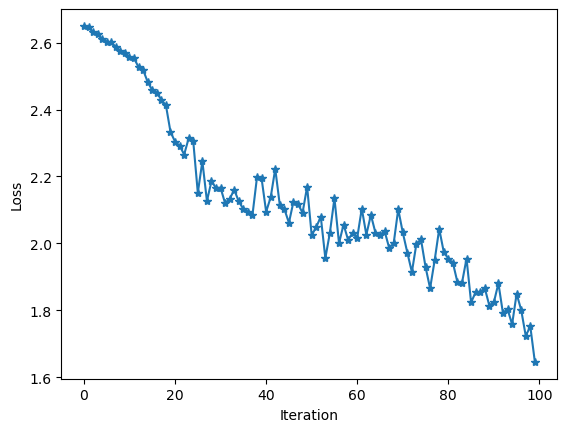

In [213]:
# RNN训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
train(rnn_net, lr = 0.0005, steps = 100, batch_size = 256)


Iteration number: 5 Loss: 2.611
Iteration number: 10 Loss: 2.5737
Iteration number: 15 Loss: 2.5273
Iteration number: 20 Loss: 2.4021
Iteration number: 25 Loss: 2.1936
Iteration number: 30 Loss: 2.1884
Iteration number: 35 Loss: 2.2075
Iteration number: 40 Loss: 2.2579
Iteration number: 45 Loss: 2.1132
Iteration number: 50 Loss: 2.1113
Iteration number: 55 Loss: 2.0756
Iteration number: 60 Loss: 2.1723
Iteration number: 65 Loss: 2.0619
Iteration number: 70 Loss: 2.1242
Iteration number: 75 Loss: 2.0593
Iteration number: 80 Loss: 2.0594
Iteration number: 85 Loss: 1.9996
Iteration number: 90 Loss: 1.9963
Iteration number: 95 Loss: 2.0604
Iteration number: 100 Loss: 1.9985


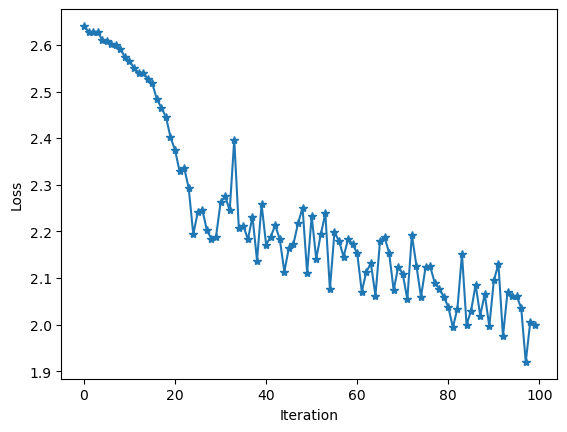

In [198]:
# LSTM训练
n_hidden = 128
lstm_net = LSTM_net(n_letters, n_hidden, n_tags)
train(lstm_net, lr = 0.0005, steps = 100, batch_size = 256)


### 模型效果评价


分别输出RNN模型和LSTM模型在训练集和测试集上的正确率。**注意最终提交的版本必须已经正确显示这四个值，如果需要助教重新跑模型得到结果，会扣除2分。**


In [199]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [200]:
#create a function to evaluate model

def eval_test(net):
     correct = 0
     for i in range(len(X_test)):
        name,lang = X_test[i],y_test[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_test)

     return accuracy

In [201]:
#create a function to evaluate model

def eval_train(net):
     correct = 0
     for i in range(len(X_train)):
        name,lang = X_train[i],y_train[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_train)

     return accuracy

In [214]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果
train set accuracy:0.3936
test set accuracy:0.4027


In [205]:
print("LSTM结果")
print("train set accuracy:"+str(round(eval_train(lstm_net),4)))
print("test set accuracy:"+str(round(eval_test(lstm_net),4)))

LSTM结果
train set accuracy:0.3639
test set accuracy:0.3618
